Aim of this task is to train CNN model being able to perform multi-label classification. Dataset contains images of hands imitating gestures used in Rock/Paper/Scissors game. To create final training set, two images and their labels are being selected randomly and contatenated. 

# 1.Settings

###1.1 Loading data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
src_test = "../rps_test"
src_train = "../rps_train"

###1.2 Connect to GPU

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


###1.3 Imports

In [5]:
import os, cv2
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report

# 2.Data processing

### 2.1 Loading images and creating labels

Both images and labels were converted into numpy arrays. Labels consists of ones and zeros to enable multi-label classification.

Rock -> [ 1 0 0 ],

Paper -> [ 0 1 0 ],

Scissors -> [ 0 0 1 ]

In [6]:
def get_data(path):

  arrays = []
  labels = []
  
  for img in os.listdir(path):
    image = cv2.imread(os.path.join(path, img))
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    arrays.append(rgb_image)

    if "rock" in img:
      labels.append(np.array([1,0,0]))
    elif "paper" in img:
      labels.append(np.array([0,1,0]))
    elif "scissor" in img:
      labels.append(np.array([0,0,1]))

  return np.array(arrays),np.array(labels)

In [7]:
train_im, train_lab = get_data(src_train)
test_im, test_lab = get_data(src_test)

Sample image and label

[0 0 1]


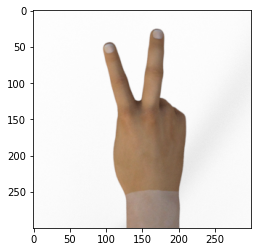

In [8]:
plt.imshow(test_im[300], cmap="gray")
print(test_lab[300])

### 2.2 Assembling dataset

Two images picked at random are being concatenated horizontally.
Also their labels are getting merged. If selected images belong to different classes, their label gets multiclass shape like [ 0 1 1 ]. 
If both images belong to the same class, label remains unchanged --> [ 1 0 0 ]


In [9]:
def get_concatenated_set(image_set, label_set, n_samples=1000):
  images = []
  labels = []
  
  for _ in range (n_samples):
    idx_1 = np.random.randint(len(image_set))
    idx_2 = np.random.randint(len(image_set))
  
    image = np.concatenate([image_set[idx_1], image_set[idx_2]], axis=1)
    images.append(image)

    if (label_set[idx_1] == label_set[idx_2]).all():
      labels.append(label_set[idx_1])
    else:
      label = label_set[idx_1] + label_set[idx_2]
      labels.append(label)

  return np.array(images), np.array(labels)

Creating traing and test sets

In [10]:
X_train, y_train = get_concatenated_set(train_im, train_lab, n_samples=1000)
X_test, y_test = get_concatenated_set(test_im, test_lab, n_samples=1000)

Sample concatenated image and its label

[0 1 1]


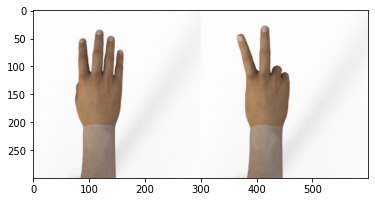

In [11]:
plt.imshow(X_test[5])
print(y_test[5])

# 3.Convolutional Neural Network 

### 3.1 Model Architecture

In [18]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[300,600,3]))
model.add(keras.layers.ZeroPadding2D(padding=2))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(5,5), data_format='channels_last'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Conv2D(filters=32, kernel_size=(5,5), data_format='channels_last'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), data_format='channels_last', padding="same"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), data_format='channels_last', padding="same"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3), data_format='channels_last', padding="same"))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(filters=256, kernel_size=(1,1), data_format='channels_last', padding="same"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(3, activation="sigmoid"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_1 (ZeroPaddi  (None, 304, 604, 3)      0         
 ng2D)                                                           
                                                                 
 conv2d_5 (Conv2D)           (None, 300, 600, 32)      2432      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 150, 300, 32)     0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 150, 300, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 146, 296, 32)      25632     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 73, 148, 32)     

### 3.2 Model compilation

In [19]:
start = 0.0001
min = 0.00001
max = 0.001
rampup_epochs = 10
sustain_epochs = 10
decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max - start)/rampup_epochs * epoch + start
  elif epoch < rampup_epochs + sustain_epochs:
    return max
  else:
    return min
    
lr = keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

In [20]:
model.compile(loss="binary_crossentropy",
             optimizer=Adam(),
             metrics=["accuracy"])

### 3.3 Trening

In [22]:
history = model.fit(X_train, y_train, epochs=40,
                   batch_size=32, validation_split=0.15,
                    shuffle=True, callbacks=[lr])


Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/40
27/27 [==============================] - 5s 184ms/step - loss: 3.8572 - accuracy: 0.3635 - val_loss: 6.8951 - val_accuracy: 0.5533 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler setting learning rate to 0.00019.
Epoch 2/40
27/27 [==============================] - 5s 183ms/step - loss: 3.2609 - accuracy: 0.4106 - val_loss: 3.5367 - val_accuracy: 0.3933 - lr: 1.9000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.00028.
Epoch 3/40
27/27 [==============================] - 5s 183ms/step - loss: 2.8718 - accuracy: 0.4224 - val_loss: 4.1585 - val_accuracy: 0.4333 - lr: 2.8000e-04

Epoch 00004: LearningRateScheduler setting learning rate to 0.00036999999999999994.
Epoch 4/40
27/27 [==============================] - 5s 195ms/step - loss: 2.3070 - accuracy: 0.4741 - val_loss: 2.8309 - val_accuracy: 0.3600 - lr: 3.7000e-04

Epoch 00005: LearningRateScheduler setting learning rate to 0.0004599

### 3.4 Loss function

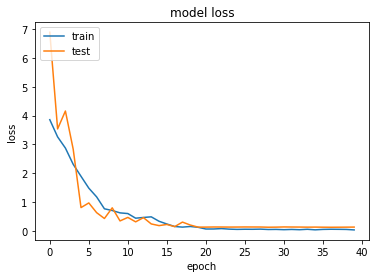

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 3.5 Model aacuracy

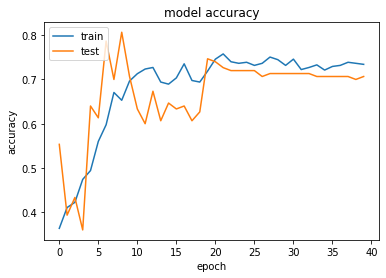

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 4.Results

In [25]:
y_pred = model.predict(X_test)
y_pred = np.rint(y_pred)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.99      0.92       536
           1       0.94      0.76      0.84       556
           2       0.81      0.88      0.84       571

   micro avg       0.86      0.87      0.87      1663
   macro avg       0.87      0.87      0.87      1663
weighted avg       0.87      0.87      0.87      1663
 samples avg       0.89      0.89      0.87      1663

